## Fit AuotoARIMA

In [1]:
import pandas as pd


# Load the dataset
file_path = 'MS_31285_POD_916_CPU.csv'
data = pd.read_csv(file_path, parse_dates=True)

# Convert the timestamp to the desired format
# Start date is 01/01/2022
start_date = pd.Timestamp('2022-01-01')

# Convert the timestamp from milliseconds to seconds and add it to the start date
data['timestamp'] = data['timestamp'].apply(lambda x: start_date + pd.Timedelta(seconds=x/1000))


# Creating the two univariate datasets with the corrected timestamp
cpu_usage_dataset_with_corrected_timestamp = data[['timestamp', 'cpu_utilization']].copy()
cpu_usage_dataset_with_corrected_timestamp  = cpu_usage_dataset_with_corrected_timestamp.rename(columns={'cpu_utilization': 'y', 'timestamp': 'ds'})

#Resample to hours
cpu_usage_dataset_with_corrected_timestamp['ds'] = pd.to_datetime(cpu_usage_dataset_with_corrected_timestamp['ds'])
cpu_usage_dataset_with_corrected_timestamp.set_index('ds', inplace=True)
cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.resample('H').mean()
cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.fillna(0) 

cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.reset_index()


cpu_usage_dataset_with_corrected_timestamp['unique_id'] = 'MS_31285_POD_916_CPU'

cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.head(7*24) #Select last 7 days of data to make example faster

# Displaying the first few rows of each corrected dataset to verify
cpu_usage_dataset_with_corrected_timestamp




,ds,y,unique_id
0,2022-01-01 00:00:00,0.408520,MS_31285_POD_916_CPU
1,2022-01-01 01:00:00,0.342241,MS_31285_POD_916_CPU
2,2022-01-01 02:00:00,0.292618,MS_31285_POD_916_CPU
3,2022-01-01 03:00:00,0.274463,MS_31285_POD_916_CPU
4,2022-01-01 04:00:00,0.289964,MS_31285_POD_916_CPU
...,...,...,...
163,2022-01-07 19:00:00,0.520336,MS_31285_POD_916_CPU
164,2022-01-07 20:00:00,0.545423,MS_31285_POD_916_CPU
165,2022-01-07 21:00:00,0.554506,MS_31285_POD_916_CPU
166,2022-01-07 22:00:00,0.535700,MS_31285_POD_916_CPU


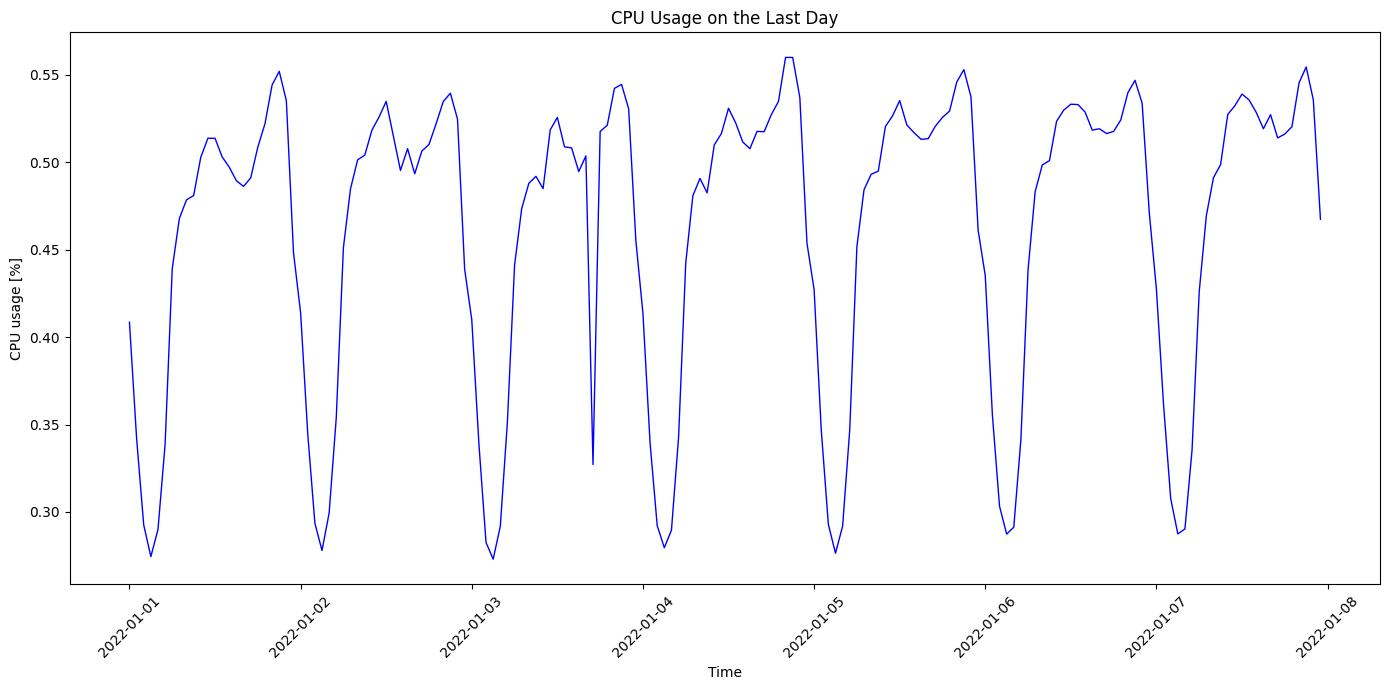

In [2]:
import matplotlib.pyplot as plt

# Plotting the CPU usage data for the last day
plt.figure(figsize=(14, 7))
plt.plot(cpu_usage_dataset_with_corrected_timestamp['ds'], cpu_usage_dataset_with_corrected_timestamp['y'], color='blue', linewidth=1)
plt.title('CPU Usage on the Last Day')
plt.xlabel('Time')
plt.ylabel('CPU usage [%]')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [3]:
from statsforecast import StatsForecast



/home/simone/.local/lib/python3.8/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
from statsforecast.models import (
    AutoARIMA,
    AutoTheta,
    AutoETS,
    AutoCES,
    MSTL,
    SeasonalNaive,
    WindowAverage,
    SeasonalWindowAverage,
    Naive
)

models = [
    AutoARIMA(season_length=24),
    AutoTheta(season_length=24),
    AutoETS(season_length=24),
    AutoCES(season_length=24),
    MSTL(season_length=24),
    SeasonalNaive(season_length=24), 
    WindowAverage(window_size=24), 
    SeasonalWindowAverage(window_size=1, season_length=24),
    Naive()
]

sf = StatsForecast( 
    models=models,
    freq='H',
    fallback_model = SeasonalNaive(season_length=24),
    n_jobs=-1,
)

#forecasts_df = sf.forecast(df=cpu_usage_dataset_with_corrected_timestamp, h=48, level=[90])
#forecasts_df

In [5]:
#sf.plot(cpu_usage_dataset_with_corrected_timestamp,forecasts_df)


In [6]:
crossvaldation_df = sf.cross_validation(
    df=cpu_usage_dataset_with_corrected_timestamp,
    h=24,
    step_size=48,
    n_windows=1
)

/home/simone/.local/lib/python3.8/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [7]:
crossvaldation_df

,ds,cutoff,y,AutoARIMA,AutoTheta,AutoETS,CES,MSTL,SeasonalNaive,WindowAverage,SeasWA,Naive
unique_id,,,,,,,,,,,,
MS_31285_POD_916_CPU,2022-01-07 00:00:00,2022-01-06 23:00:00,0.427334,0.425640,0.427636,0.425874,0.431117,0.428365,0.435215,0.469619,0.435215,0.47113
MS_31285_POD_916_CPU,2022-01-07 01:00:00,2022-01-06 23:00:00,0.361315,0.347461,0.351395,0.353354,0.355984,0.353138,0.355500,0.469619,0.355500,0.47113
MS_31285_POD_916_CPU,2022-01-07 02:00:00,2022-01-06 23:00:00,0.307714,0.295771,0.298054,0.301609,0.303938,0.300848,0.303301,0.469619,0.303301,0.47113
MS_31285_POD_916_CPU,2022-01-07 03:00:00,2022-01-06 23:00:00,0.287457,0.280542,0.283663,0.287021,0.290524,0.286311,0.287339,0.469619,0.287339,0.47113
MS_31285_POD_916_CPU,2022-01-07 04:00:00,2022-01-06 23:00:00,0.290307,0.291091,0.297781,0.301585,0.303679,0.299263,0.291319,0.469619,0.291319,0.47113
MS_31285_POD_916_CPU,2022-01-07 05:00:00,2022-01-06 23:00:00,0.335666,0.344243,0.353236,0.355012,0.358071,0.353174,0.341631,0.469619,0.341631,0.47113
MS_31285_POD_916_CPU,2022-01-07 06:00:00,2022-01-06 23:00:00,0.425971,0.445069,0.452219,0.449397,0.453380,0.451047,0.438483,0.469619,0.438483,0.47113
MS_31285_POD_916_CPU,2022-01-07 07:00:00,2022-01-06 23:00:00,0.469441,0.482981,0.489194,0.488933,0.490582,0.487306,0.483274,0.469619,0.483274,0.47113
MS_31285_POD_916_CPU,2022-01-07 08:00:00,2022-01-06 23:00:00,0.491185,0.494025,0.502482,0.500110,0.503905,0.499638,0.498477,0.469619,0.498477,0.47113


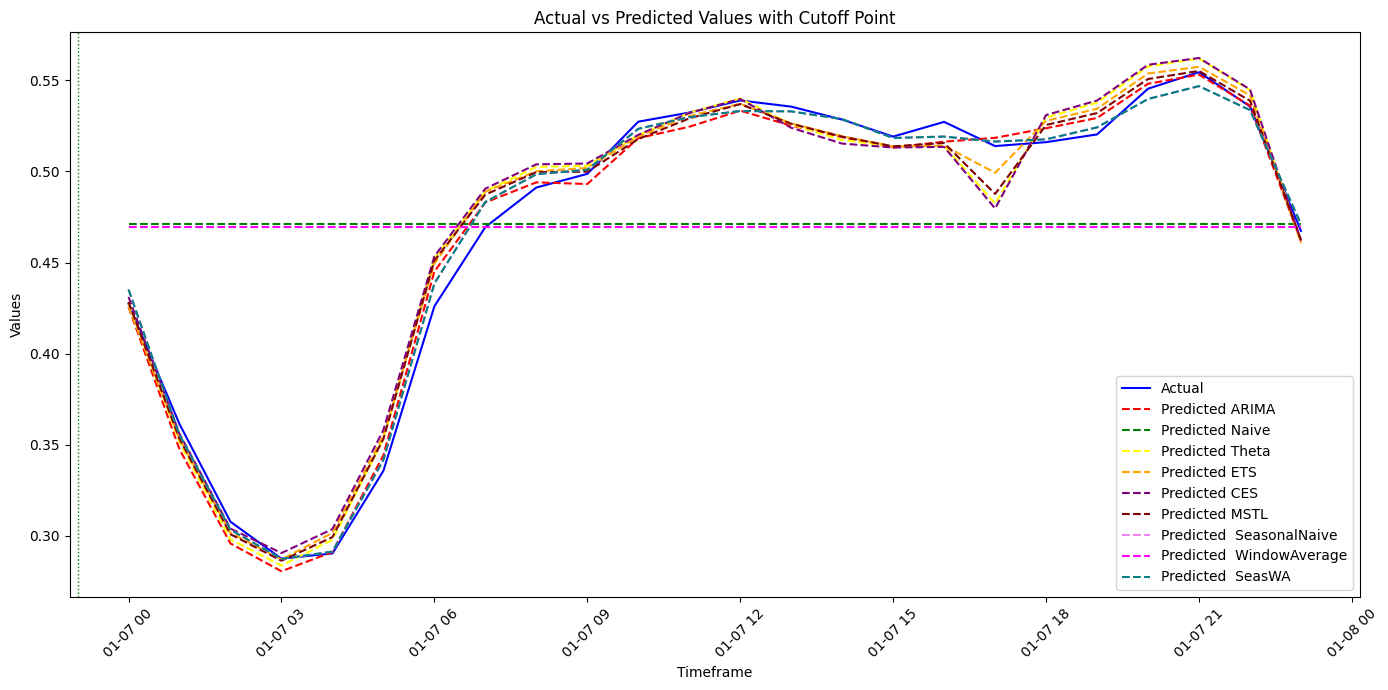

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoARIMA'], label='Predicted ARIMA', color='red', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['Naive'], label='Predicted Naive', color='green', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoTheta'], label='Predicted Theta', color='yellow', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoETS'], label='Predicted ETS', color='orange', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['CES'], label='Predicted CES', color='purple', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['MSTL'], label='Predicted MSTL', color='maroon', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasonalNaive'], label='Predicted  SeasonalNaive', color='violet', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['WindowAverage'], label='Predicted  WindowAverage', color='magenta', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasWA'], label='Predicted  SeasWA', color='teal', linestyle='--')

for cutoff in crossvaldation_df['cutoff'].unique():
    plt.axvline(x=cutoff, color='green', linestyle=':', linewidth=1)

plt.title('Actual vs Predicted Values with Cutoff Point')
plt.xlabel('Timeframe')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [9]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

# Initialize and fit the Prophet model
model = Prophet()

model.fit(cpu_usage_dataset_with_corrected_timestamp)

Importing plotly failed. Interactive plots will not work.
16:40:38 - cmdstanpy - INFO - Chain [1] start processing
16:40:38 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
df_cv = cross_validation(model, horizon='1 days', initial='5 days')

  0%|          | 0/2 [00:00<?, ?it/s]

16:40:38 - cmdstanpy - INFO - Chain [1] start processing
16:40:38 - cmdstanpy - INFO - Chain [1] done processing
16:40:38 - cmdstanpy - INFO - Chain [1] start processing
16:40:38 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
pd.set_option('display.max_rows', 97)
df_cv = df_cv.sort_values(by='ds')
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-01-06 12:00:00,0.534431,0.512256,0.558619,0.533186,2022-01-06 11:00:00
1,2022-01-06 13:00:00,0.536462,0.510278,0.558947,0.532982,2022-01-06 11:00:00
2,2022-01-06 14:00:00,0.525510,0.502018,0.550325,0.528699,2022-01-06 11:00:00
3,2022-01-06 15:00:00,0.508354,0.485482,0.531825,0.518390,2022-01-06 11:00:00
4,2022-01-06 16:00:00,0.497933,0.473909,0.521169,0.519155,2022-01-06 11:00:00
5,2022-01-06 17:00:00,0.503030,0.477574,0.526735,0.516417,2022-01-06 11:00:00
6,2022-01-06 18:00:00,0.521916,0.497735,0.546610,0.517643,2022-01-06 11:00:00
7,2022-01-06 19:00:00,0.544367,0.522419,0.568152,0.524204,2022-01-06 11:00:00
8,2022-01-06 20:00:00,0.558558,0.535771,0.581421,0.539785,2022-01-06 11:00:00
9,2022-01-06 21:00:00,0.556163,0.533058,0.581209,0.546851,2022-01-06 11:00:00


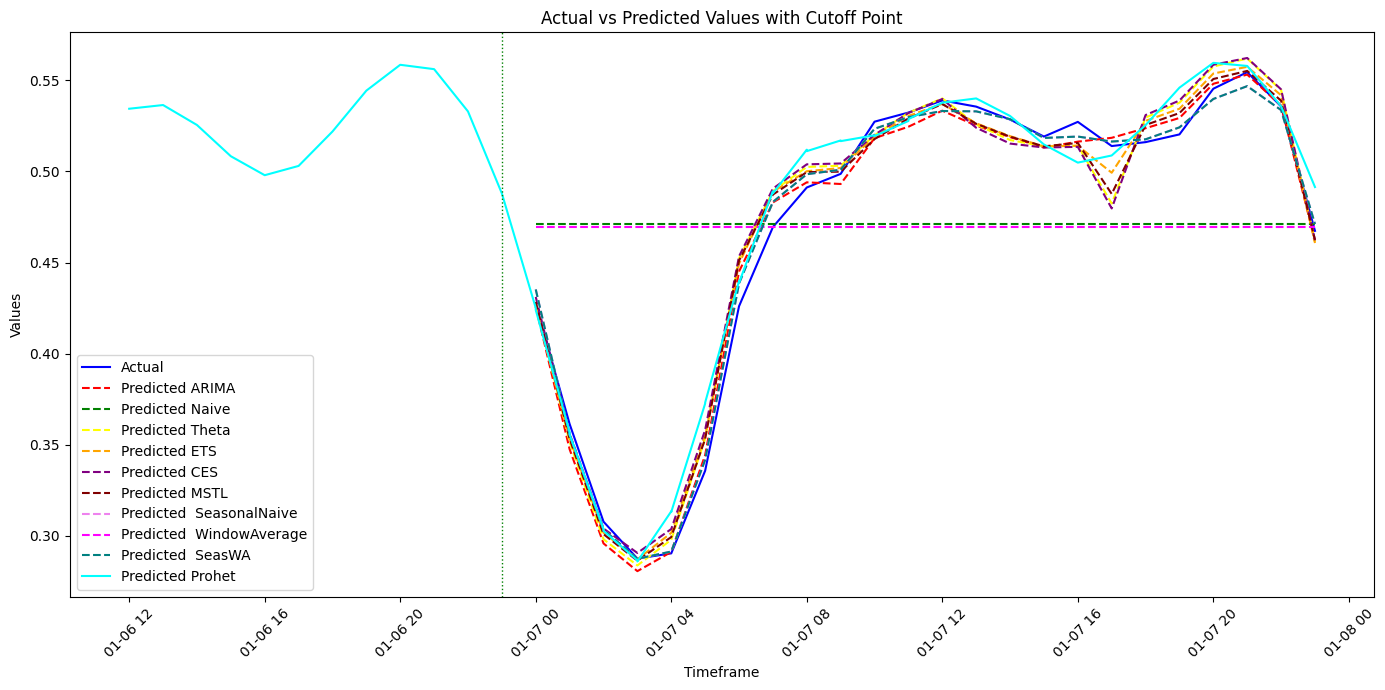

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoARIMA'], label='Predicted ARIMA', color='red', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['Naive'], label='Predicted Naive', color='green', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoTheta'], label='Predicted Theta', color='yellow', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoETS'], label='Predicted ETS', color='orange', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['CES'], label='Predicted CES', color='purple', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['MSTL'], label='Predicted MSTL', color='maroon', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasonalNaive'], label='Predicted  SeasonalNaive', color='violet', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['WindowAverage'], label='Predicted  WindowAverage', color='magenta', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasWA'], label='Predicted  SeasWA', color='teal', linestyle='--')

plt.plot(df_cv['ds'], df_cv['yhat'], label='Predicted Prohet', color='cyan', linestyle='-')


for cutoff in crossvaldation_df['cutoff'].unique():
    plt.axvline(x=cutoff, color='green', linestyle=':', linewidth=1)

plt.title('Actual vs Predicted Values with Cutoff Point')
plt.xlabel('Timeframe')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [13]:
crossvaldation_df = crossvaldation_df.reset_index()
crossvaldation_df['prophet'] = df_cv['yhat']
crossvaldation_df

,unique_id,ds,cutoff,y,AutoARIMA,AutoTheta,AutoETS,CES,MSTL,SeasonalNaive,WindowAverage,SeasWA,Naive,prophet
0,MS_31285_POD_916_CPU,2022-01-07 00:00:00,2022-01-06 23:00:00,0.427334,0.425640,0.427636,0.425874,0.431117,0.428365,0.435215,0.469619,0.435215,0.47113,0.534431
1,MS_31285_POD_916_CPU,2022-01-07 01:00:00,2022-01-06 23:00:00,0.361315,0.347461,0.351395,0.353354,0.355984,0.353138,0.355500,0.469619,0.355500,0.47113,0.536462
2,MS_31285_POD_916_CPU,2022-01-07 02:00:00,2022-01-06 23:00:00,0.307714,0.295771,0.298054,0.301609,0.303938,0.300848,0.303301,0.469619,0.303301,0.47113,0.525510
3,MS_31285_POD_916_CPU,2022-01-07 03:00:00,2022-01-06 23:00:00,0.287457,0.280542,0.283663,0.287021,0.290524,0.286311,0.287339,0.469619,0.287339,0.47113,0.508354
4,MS_31285_POD_916_CPU,2022-01-07 04:00:00,2022-01-06 23:00:00,0.290307,0.291091,0.297781,0.301585,0.303679,0.299263,0.291319,0.469619,0.291319,0.47113,0.497933
5,MS_31285_POD_916_CPU,2022-01-07 05:00:00,2022-01-06 23:00:00,0.335666,0.344243,0.353236,0.355012,0.358071,0.353174,0.341631,0.469619,0.341631,0.47113,0.503030
6,MS_31285_POD_916_CPU,2022-01-07 06:00:00,2022-01-06 23:00:00,0.425971,0.445069,0.452219,0.449397,0.453380,0.451047,0.438483,0.469619,0.438483,0.47113,0.521916
7,MS_31285_POD_916_CPU,2022-01-07 07:00:00,2022-01-06 23:00:00,0.469441,0.482981,0.489194,0.488933,0.490582,0.487306,0.483274,0.469619,0.483274,0.47113,0.544367
8,MS_31285_POD_916_CPU,2022-01-07 08:00:00,2022-01-06 23:00:00,0.491185,0.494025,0.502482,0.500110,0.503905,0.499638,0.498477,0.469619,0.498477,0.47113,0.558558
9,MS_31285_POD_916_CPU,2022-01-07 09:00:00,2022-01-06 23:00:00,0.498672,0.493112,0.503142,0.501900,0.504378,0.499880,0.500948,0.469619,0.500948,0.47113,0.556163


In [14]:
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals


In [15]:
evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)
evaluation_df.head()

,AutoARIMA,AutoTheta,AutoETS,CES,MSTL,SeasonalNaive,WindowAverage,SeasWA,Naive,prophet,best_model
unique_id,,,,,,,,,,,
MS_31285_POD_916_CPU,0.000074,0.00017,0.000116,0.000201,0.000123,0.000034,0.00733,0.000034,0.007334,0.019279,SeasonalNaive
